In [2]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

In [3]:
labels_csv = pd.read_csv("data\\NAACL_SRW_2016.csv")
labels_csv.head()

,tweet_id,label
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism


In [4]:
tweets_csv = pd.read_csv("data\\NAACL_SRW_2016_tweets.csv", header=0, delimiter=",bbbbbbbbbbb", quoting=3)

for i in range(len(tweets_csv)):
    s = tweets_csv.iloc[i,1]
    s = s[1:-1]
    tweets_csv.iloc[i,1] = s

tweets_csv.head()

C:\Users\Mahdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,tweet_id,tweet
0,572332655397629952,These girls are the equivalent of the irritati...
1,572341498827522049,Drasko they didn't cook half a bird you idiot ...
2,572340476503724032,Hopefully someone cooks Drasko in the next ep ...
3,572334712804384768,of course you were born in serbia...you're as ...
4,575949086055997440,#MKR Lost the plot - where's the big Texan wi...


In [5]:
merged = tweets_csv.merge(labels_csv, on='tweet_id')
merged = merged.drop_duplicates()
merged = merged.reset_index(drop=True)
merged.head()

,tweet_id,tweet,label
0,572332655397629952,These girls are the equivalent of the irritati...,racism
1,572341498827522049,Drasko they didn't cook half a bird you idiot ...,racism
2,572341498827522049,Drasko they didn't cook half a bird you idiot ...,none
3,572340476503724032,Hopefully someone cooks Drasko in the next ep ...,racism
4,572340476503724032,Hopefully someone cooks Drasko in the next ep ...,none


In [6]:
tweets_list = merged['tweet'].tolist()
labels_list = merged['label'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [7]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [8]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [9]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [10]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [11]:
embedding_vecor_length = 200

model_embed = Sequential()
model_embed.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],
                          input_shape=(max_wordNum,),trainable=False, name='Embedding'))
model_embed.compile(optimizer='RMSprop', loss='mean_squared_error')
#print (model_embed.summary())
X_train_embedded = model_embed.predict(X_train)
X_valid_embedded = model_embed.predict(X_valid)

In [12]:
#embedding_vecor_length = 200
latent_dim = 100

inputs = Input(shape=(max_wordNum,embedding_vecor_length))

#embedding = Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],trainable=True)(inputs)

encoded = LSTM(latent_dim)(inputs) #(embedding)

decoded1 = RepeatVector(max_wordNum)(encoded)
decoded2 = LSTM(embedding_vecor_length, return_sequences=True)(decoded1)
#decoded3 = LSTM(max_wordNum, return_sequences=False)(decoded2)
#decoded3 = TimeDistributed(Dense(1))(decoded2) 
#decoded3 = Reshape((max_wordNum,))(decoded3)

sequence_autoencoder = Model(inputs, decoded2)

encoder = Model(inputs, encoded)

sequence_autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')
#sequence_autoencoder.compile(loss='binary_crossentropy', optimizer='adam')


print (sequence_autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 33, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 200)           240800    
Total params: 361,200
Trainable params: 361,200
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

autoencoder_train = sequence_autoencoder.fit(X_train_embedded, X_train_embedded,
                            batch_size=100,
                            epochs=20,
                            validation_data=(X_valid_embedded, X_valid_embedded)
                            ,callbacks=callbacks
                            )

Train on 5572 samples, validate on 2782 samples
Epoch 1/20
5572/5572 [==============================] - 16s 3ms/step - loss: 0.0753 - val_loss: 0.0719
Epoch 2/20
5572/5572 [==============================] - 17s 3ms/step - loss: 0.0734 - val_loss: 0.0715
Epoch 3/20
5572/5572 [==============================] - 16s 3ms/step - loss: 0.0732 - val_loss: 0.0716
Epoch 4/20
5572/5572 [==============================] - 15s 3ms/step - loss: 0.0729 - val_loss: 0.0700
Epoch 5/20
5572/5572 [==============================] - 16s 3ms/step - loss: 0.0722 - val_loss: 0.0724
Epoch 6/20
5572/5572 [==============================] - 17s 3ms/step - loss: 0.0716 - val_loss: 0.0696
Epoch 7/20
5572/5572 [==============================] - 27s 5ms/step - loss: 0.0711 - val_loss: 0.0688
Epoch 8/20
5572/5572 [==============================] - 29s 5ms/step - loss: 0.0708 - val_loss: 0.0696
Epoch 9/20
5572/5572 [==============================] - 30s 5ms/step - loss: 0.0706 - val_loss: 0.0685
Epoch 10/20
5572/5572 [==

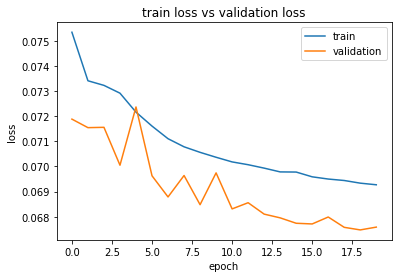

In [14]:
plt.figure()
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [15]:
X_test_embedded = model_embed.predict(X_test)
score = sequence_autoencoder.evaluate(X_test_embedded, X_test_embedded, verbose=0)
print('Test loss:', score)

Test loss: 0.06725679720807118


In [16]:
X_train_encoded = encoder.predict(X_train_embedded)
X_valid_encoded = encoder.predict(X_valid_embedded)

class_count = Y.shape[1]

model = Sequential()
model.add(Dense(20,activation='relu',name='Hidden_Layer_1', input_shape=(latent_dim,)))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train_encoded, y_train, 
                    validation_data=[X_valid_encoded,y_valid],
                    epochs=100, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 5572 samples, validate on 2782 samples
Epoch 1/100
5572/5572 [==============================] - 1s 91us/step - loss: 0.8036 - acc: 0.6619 - val_loss: 0.6031 - val_acc: 0.7477
Epoch 2/100
5572/5572 [==============================] - 0s 27us/step - loss: 0.5843 - acc: 0.7419 - val_loss: 0.5346 - val_acc: 0.7912
Epoch 3/100
5572/5572 [==============================] - 0s 21us/step - loss: 0.5344 - acc: 0.7830 - val_loss: 0.4992 - val_acc: 0.8063
Epoch 4/100
5572/5572 [==============================] - 0s 19us/step - loss: 0.5080 - acc: 0.7898 - val_loss: 0.4819 - val_acc: 0.8113
Epoch 5/100
5572/5572 [==============================] - 0s 18us/step - loss: 0.4915 - acc: 0.7985 - val_loss: 0.4680 - val_acc: 0.8124
Epoch 6/100
5572/5572 [==============================] - 0s 20us/step - loss: 0.4812 - acc: 0.7990 - val_loss: 0.4590 - val_acc: 0.8163
Epoch 7/100
5572/5572 [==============================] - 0s 18us/step - loss: 0.4729 - acc: 0.8001 - val_loss: 0.4541 - val_acc: 0.8181


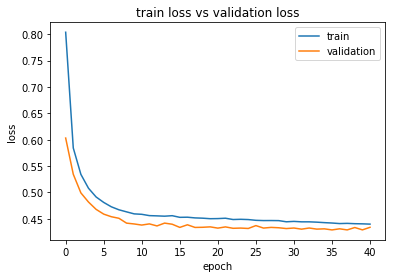

In [18]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [19]:
X_test_encoded = encoder.predict(X_test_embedded)
score = model.evaluate(X_test_encoded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43793215584444617
Test accuracy: 0.822262118491921
